In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import xarray as xr

In [9]:
rootdir = '/work/e786/e786/shared/datasets/bSOSE'
niter = 133
freq = '5day'
filename_prefix = 'bsose_i'+str(niter)+'_2013to2018_'+freq+'_'
filename_suffix = '.nc'
variables = ['Uvel','Vvel','Wvel','Theta','Salt','MLD']
path = []
for variable in variables:
    filename = filename_prefix+variable+filename_suffix
    path.append(rootdir+'/ITER'+str(niter)+'/'+filename)

In [10]:
path

['/work/e786/e786/shared/datasets/bSOSE/ITER133/bsose_i133_2013to2018_5day_Uvel.nc',
 '/work/e786/e786/shared/datasets/bSOSE/ITER133/bsose_i133_2013to2018_5day_Vvel.nc',
 '/work/e786/e786/shared/datasets/bSOSE/ITER133/bsose_i133_2013to2018_5day_Wvel.nc',
 '/work/e786/e786/shared/datasets/bSOSE/ITER133/bsose_i133_2013to2018_5day_Theta.nc',
 '/work/e786/e786/shared/datasets/bSOSE/ITER133/bsose_i133_2013to2018_5day_Salt.nc',
 '/work/e786/e786/shared/datasets/bSOSE/ITER133/bsose_i133_2013to2018_5day_MLD.nc']

In [3]:
import pandas as pd
import numpy as np
import bsose.preprocess as pp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import copy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpath
import utils.geo as geo
from scipy.signal import argrelextrema

In [2]:
rootdir = '/work/e786/e786/shared/datasets/bSOSE'
ds,xgrid = pp.load_bsose(rootdir=rootdir,niter=133)

/home/aos/graemem/miniconda3/envs/parcels/lib/python3.6/site-packages/xarray/core/rolling.py:807: FutureWarning: Passing ``keep_attrs`` to ``coarsen`` is deprecated and will raise an error in xarray 0.19. Please pass ``keep_attrs`` directly to the applied function, i.e. use ``ds.coarsen(...).mean(keep_attrs=False)`` instead of ``ds.coarsen(..., keep_attrs=False).mean()`` Note that keep_attrs is now True per default.
  FutureWarning,


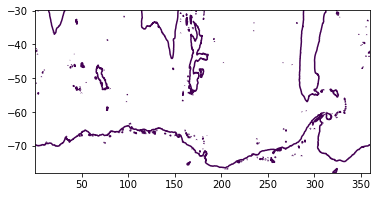

In [250]:
# Find Ross Sea shelf
informalname = 'RossShelf'
bathyT = 1000
fig,ax=plt.subplots(figsize=(6,3))
cs = ax.contour(ds['XC'],ds['YC'],ds['Depth'],levels=[bathyT]);

In [251]:
# Find contour closest to specified lat-lon
startpoint=[160,-70]
initdistance = 1e5
for i in cs.collections[0].get_paths():
    v = i.vertices
    dlon = v[:,0]-startpoint[0]
    dlat = v[:,1]-startpoint[1]
    xdistance, ydistance = geo._degrees_to_meters(dlon,dlat,v[:,0],v[:,1])
    distance = (xdistance*1e-3)**2 + (ydistance*1e-3)**2
    minimum = np.min(distance)
    if minimum < initdistance:
        initdistance = minimum
        minpointnow = np.argmin(distance)
        vnow = v
        inow = i

In [252]:
np.diff(vnow[:,0])

array([0.16666666, 0.16666669, 0.16666669, ..., 0.05555216, 0.11110433,
       0.16668701])

In [253]:
# Calculate the distance from the start point to each point on the contour
dlon = np.diff(vnow[:,0])
dlat = np.diff(vnow[:,1])
lonm = 0.5*(vnow[1:,0]+vnow[:-1,0])
latm = 0.5*(vnow[1:,1]+vnow[:-1,1])
dx, dy = geo._degrees_to_meters(dlon,dlat,lonm,latm)
distance = np.sqrt(dx**2+dy**2)*1e-3

In [254]:
# Return indices of the points at equal `separation` from start point
separation = 500 # Separation distance along contour
cumdistance = np.cumsum(distance)
cumdistance = cumdistance-cumdistance[minpointnow]
minima, = argrelextrema(cumdistance[minpointnow:]%separation,np.less)+minpointnow
minima = np.append(minpointnow,minima)
maxdistance = 5000 # Max distance along contour from starting point
maxind = np.argmin(np.abs(cumdistance-maxdistance))
minima = minima[minima<maxind]

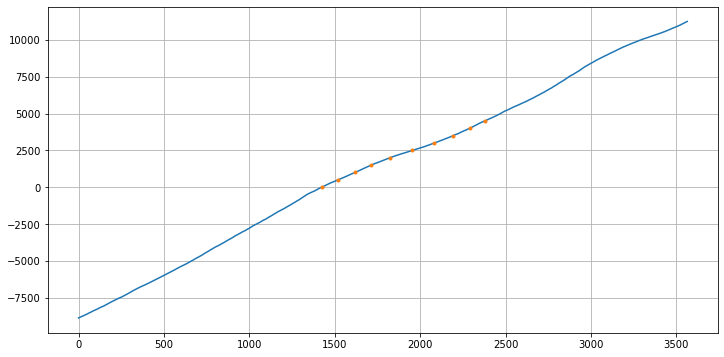

In [255]:
fig,ax = plt.subplots(figsize=(12,6))
plt.plot(cumdistance)
plt.plot(minima,cumdistance[minima],marker='.',linestyle=' ',color='tab:orange');
plt.grid()

In [265]:
# Lat and lon of initialization positions
initlon = vnow[minima,0]
initlat = vnow[minima,1]
init = [initlon,initlat]

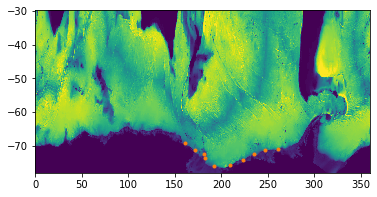

In [266]:
fig,ax = plt.subplots(figsize=(6,3))
ax.pcolormesh(ds['XC'],ds['YC'],ds['Depth'], shading='auto')
ax.plot(initlon,initlat,marker='.',linestyle=' ',color='tab:orange')

In [267]:
savename = '.'.join([informalname,'level'+str(bathyT),'sep'+str(separation),'maxd'+str(maxdistance),'txt'])
np.savetxt('../../data/'+savename,init)

In [271]:
init = np.loadtxt('../../data/'+savename)
init[0,:]

array([160.91667175, 171.58334351, 180.91667175, 182.58334351,
       192.58334351, 209.08334351, 223.58334351, 235.08334351,
       247.25      , 260.58334351])

In [258]:
Nh = 50
dh = 0.2
Nz = 100
lats = np.empty(0)
lons = np.empty(0)
depths = np.empty(0)

for i in range(len(initlon)):
    lon = initlon[i]
    lat = initlat[i]
    
    depthmin = 0
    depthmax = 1000
    
    lonV = [lon-dh/2,lon+dh/2]
    latV = [lat-dh/2,lat+dh/2]
    depthV = [depthmin,depthmax]
    
    lons1D =  np.linspace(lonV[0],lonV[1],Nh)
    lats1D = np.linspace(latV[0],latV[1],Nh)
    depths1D = np.linspace(depthV[0],depthV[1],Nz)
    
    [lons1,lats1,depths1] = np.meshgrid(lons1D,lats1D,depths1D)
    
    lons = np.concatenate((lons,lons1.flatten()))
    lats = np.concatenate((lats,lats1.flatten()))
    depths = np.concatenate((depths,depths1.flatten()))

In [273]:
lons.shape

(2500000,)

### Plot locations

In [238]:
varstr = "TRAC01"
iselect = {"time":-1}
select = {"Z":800}
da = ds[varstr].isel(
    **iselect).sel(
    **select,method='nearest')
da_masked = np.ma.masked_where(da==0,da)

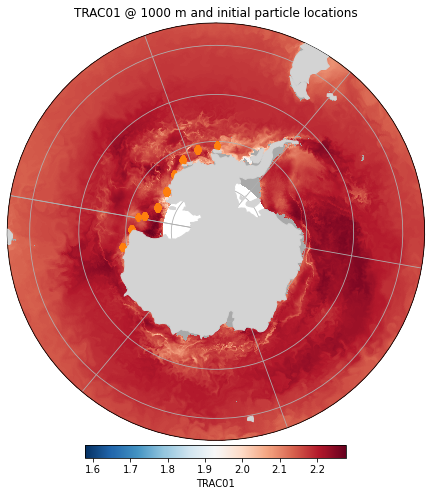

In [239]:
fig,ax = plt.subplots(figsize=(8,8),
                      subplot_kw={'projection':
                                      ccrs.SouthPolarStereo(
                                      central_longitude=-100)})
cmap = copy.copy(cm.RdBu_r)
cmap.set_bad('darkgray')
ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

im=ax.pcolormesh(ds["XC"],ds["YC"],da_masked,cmap=cmap,
              transform=ccrs.PlateCarree())
plt.colorbar(im,ax=ax,
             orientation='horizontal',
            fraction=0.03,pad=0.01,
            label=varstr)

ax.plot(lons,
        lats,
        linestyle='None',
        marker='d',
        color='tab:orange',
        transform=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, zorder=10,facecolor='lightgray')
ax.gridlines()
ax.set_title(
    varstr+(' @ %s m'%depthV[1])+' and initial particle locations');

In [8]:
varstr = "THETA"
iselect = {"time":-1}
selectslice = {"YC":slice(-65,-50)}
lonV = 360-66
select = {"XC":lonV}
da = ds[varstr].isel(
    **iselect).sel(
    **select,method='nearest').sel(
    **selectslice)
da_masked = np.ma.masked_where(da==0,da)

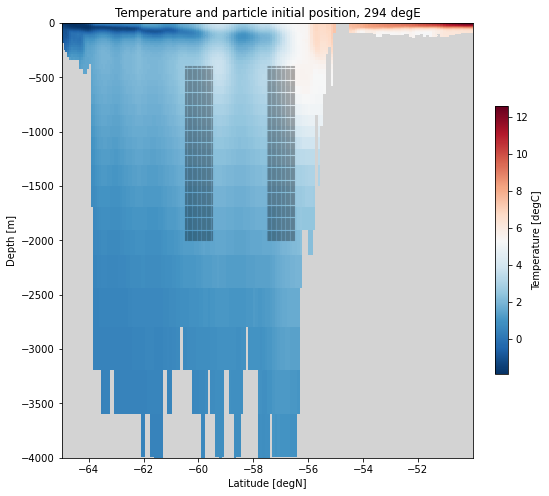

In [9]:
fig,ax = plt.subplots(figsize=(8,8))
cmap = copy.copy(cm.RdBu_r)
cmap.set_bad('lightgray')
im = ax.pcolormesh(da['YC'],da['Z'],da_masked,shading='auto',cmap=cmap)
ax.plot(lats,
        depths,
        linestyle='None',
        marker='.',
        color='k',
        markersize=0.1)
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Latitude [degN]')
ax.set_title('Temperature and particle initial position, %s degE' %str(lonV))
ax.set_ylim([-4000,0])
plt.colorbar(im,ax=ax,
             fraction=0.03,pad=0.05,
             label='Temperature [degC]')

In [13]:
df

,Coral Sites,names,Latitude,Longitude,Depth,Unnamed: 5
0,Burdwood Bank (BB),BB,54.500000,62.166667,334.0,NaN
1,Burdwood Bank (BB),BB,54.500000,62.166667,727.0,NaN
2,Burdwood Bank (BB),BB,54.500000,62.166667,816.0,NaN
3,Burdwood Bank (BB),BB,54.500000,62.166667,1419.0,NaN
4,Burdwood Bank (BB),BB,54.500000,62.166667,1879.0,NaN
5,Cape Horn (CH),CH,57.166667,66.100000,450.0,NaN
6,Cape Horn (CH),CH,57.166667,66.100000,1012.0,NaN
7,Cape Horn (CH),CH,57.166667,66.100000,1214.0,NaN
8,Cape Horn (CH),CH,57.166667,66.100000,1441.0,NaN
9,Cape Horn (CH),CH,57.166667,66.100000,1877.0,NaN


In [ ]:
N = 50
lonV = 291-10
latV = [-75, -55]
depthV = [-3000,-200]

lats1D = np.linspace(latV[0],latV[1],N)
lons1D = np.arange(231,291,10)
depths1D = np.linspace(depthV[0],depthV[1],N)

[lons,lats,depths] = np.meshgrid(lons1D,lats1D,depths1D)